Target: kind cluster, k3d cluster, k3s cluster, Microk8s
Replicas: 1, 4, 8

Variation give: 60 pipeline combination

kind (Kubernetes IN Docker): Tool for running Kubernetes clusters in Docker containers. (local dev)
k3d: A wrapper around k3s to run clusters inside Docker. (local dev)
k3s: Lightweight Kubernetes distribution from Rancher. (Production ready)
MicroK8s: Lightweight Kubernetes from Canonical (Ubuntu). (Production ready)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # optional for nicer plots if allowed
import numpy as np
from scipy.stats import pearsonr

In [10]:
# Path to your Excel file
file_path = r"C:\Users\boubouthiam.niang\workspace\bl\eco-conception\petclinic-ci-cd-energy-benchmark\petclinic\analysis\data\raw\merged-eco-ci-petclinic-benchmark-deploy-multi-replicas.xlsx"

# Load raw Excel
df = pd.read_excel(file_path)

# Strip spaces, replace special characters
df.columns = (
    df.columns.str.strip()               # remove leading/trailing spaces
              .str.replace(" ", "_")     # replace spaces with _
              .str.replace(r"[\[\]%]", "", regex=True) # remove [ ], %
)

df.head()


,Run,Pipeline_Reference,Target,Nb_Replicas,avg._CPU_utilization_,Total_Energy_Joules,avg._Power_Watts,Duration_Seconds
0,1,1,kind cluster,1,37.3074,308.978,4.11970,77
1,1,2,kind cluster,4,68.0944,789.832,6.07563,132
2,1,3,kind cluster,8,49.1119,5128.660,4.82925,1064
3,1,4,k3d cluster,1,25.3902,322.400,3.32371,98
4,1,5,k3d cluster,4,74.8453,769.059,6.57315,119


In [3]:
# Standardize column names for easier use
df.columns = (
    df.columns.str.strip()
              .str.replace(" ", "_")
              .str.replace(".", "", regex=False)
)

df.head()


,Run,Pipeline_Reference,Target,Nb_Replicas,avg_CPU_utilization_[%],Total_Energy_[Joules],avg_Power_[Watts],Duration_[Seconds]
0,1,1,kind cluster,1,37.3074,308.978,4.11970,77
1,1,2,kind cluster,4,68.0944,789.832,6.07563,132
2,1,3,kind cluster,8,49.1119,5128.660,4.82925,1064
3,1,4,k3d cluster,1,25.3902,322.400,3.32371,98
4,1,5,k3d cluster,4,74.8453,769.059,6.57315,119


In [11]:
print(df.columns.tolist())

['Run', 'Pipeline_Reference', 'Target', 'Nb_Replicas', 'avg._CPU_utilization_', 'Total_Energy_Joules', 'avg._Power_Watts', 'Duration_Seconds']


In [13]:
# Group by Target (cluster) and replicas to compute averages across runs
summary = df.groupby(["Target", "Nb_Replicas"]).agg({
    "avg._CPU_utilization_": "mean",
    "Total_Energy_Joules": "mean",
    "avg._Power_Watts": "mean",
    "Duration_Seconds": "mean"
}).reset_index()

summary


,Target,Nb_Replicas,avg._CPU_utilization_,Total_Energy_Joules,avg._Power_Watts,Duration_Seconds
0,Microk8s,1,29.03094,361.5270,3.615828,102.0
1,Microk8s,4,59.36950,1270.3648,5.560534,226.4
2,Microk8s,8,47.29944,5146.6460,4.729670,1090.4
3,k3d cluster,1,32.05702,285.6942,3.741992,80.2
4,k3d cluster,4,74.13404,1118.7438,6.522664,174.0
5,k3d cluster,8,48.38088,5094.3480,4.815974,1060.2
6,k3s cluster,1,25.96272,319.6476,3.361532,97.2
7,k3s cluster,4,59.35306,860.9620,5.555488,158.0
8,k3s cluster,8,51.41020,4508.3600,5.013890,917.2
9,kind cluster,1,35.39766,320.8618,3.975848,83.0


In [14]:
df = df.rename(columns={
    "avg._CPU_utilization_": "CPU_utilization",
    "avg._Power_Watts": "Power_Watts",
    "Total_Energy_Joules": "Energy_Joules",
    "Duration_Seconds": "Duration"
})


# Energy vs Replicas (per Cluster)

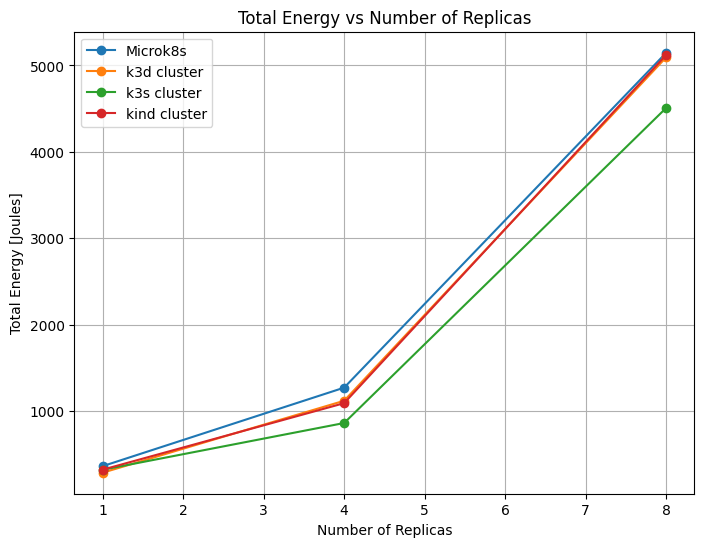

In [28]:
plt.figure(figsize=(8,6))
for cluster in summary["Target"].unique():
    subset = summary[summary["Target"] == cluster]
    plt.plot(subset["Nb_Replicas"], subset["Total_Energy_Joules"], marker="o", label=cluster)

plt.title("Total Energy vs Number of Replicas")
plt.xlabel("Number of Replicas")
plt.ylabel("Total Energy [Joules]")
plt.legend()
plt.grid(True)
plt.savefig("./eco_ci_downloaded_results/energy-accros-replicas.pdf")
plt.show()


# Duration vs Replicas

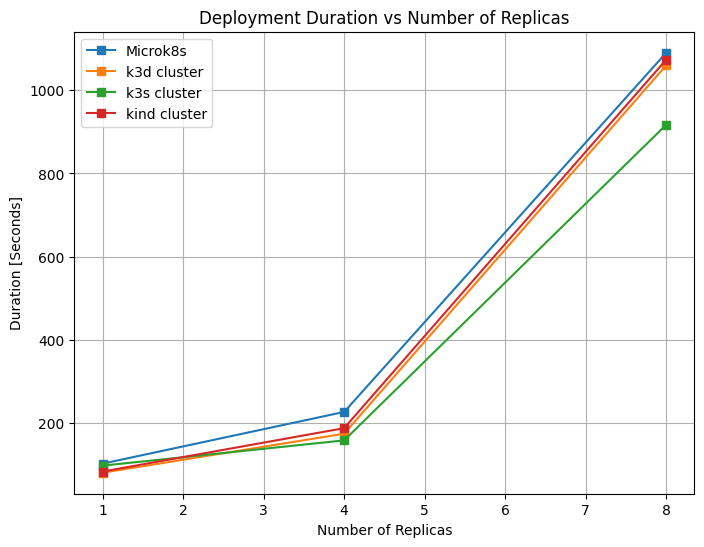

In [16]:
plt.figure(figsize=(8,6))
for cluster in summary["Target"].unique():
    subset = summary[summary["Target"] == cluster]
    plt.plot(subset["Nb_Replicas"], subset["Duration_Seconds"], marker="s", label=cluster)

plt.title("Deployment Duration vs Number of Replicas")
plt.xlabel("Number of Replicas")
plt.ylabel("Duration [Seconds]")
plt.legend()
plt.grid(True)
plt.show()


# CPU Utilization vs Replicas

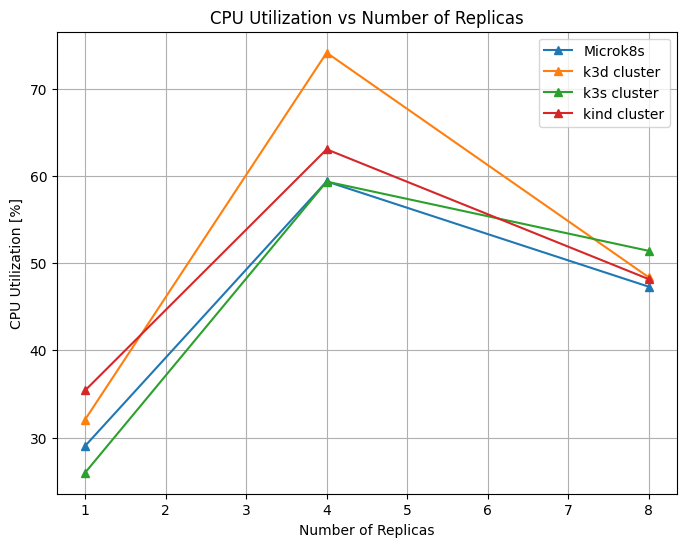

In [18]:
plt.figure(figsize=(8,6))
for cluster in summary["Target"].unique():
    subset = summary[summary["Target"] == cluster]
    plt.plot(subset["Nb_Replicas"], subset["avg._CPU_utilization_"], marker="^", label=cluster)

plt.title("CPU Utilization vs Number of Replicas")
plt.xlabel("Number of Replicas")
plt.ylabel("CPU Utilization [%]")
plt.legend()
plt.grid(True)
plt.show()


# Correlation Heatmap (Energy, Duration, CPU, Power)

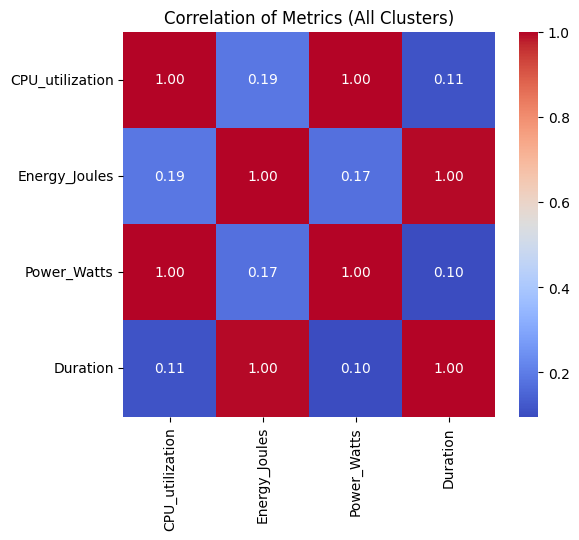

In [22]:
df = df.rename(columns={
    "avg._CPU_utilization_": "CPU_utilization",
    "avg._Power_Watts": "Power_Watts",
    "Total_Energy_Joules": "Energy_Joules",
    "Duration_Seconds": "Duration"
})

corr = df[["CPU_utilization", "Energy_Joules", "Power_Watts", "Duration"]].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Metrics (All Clusters)")
plt.show()


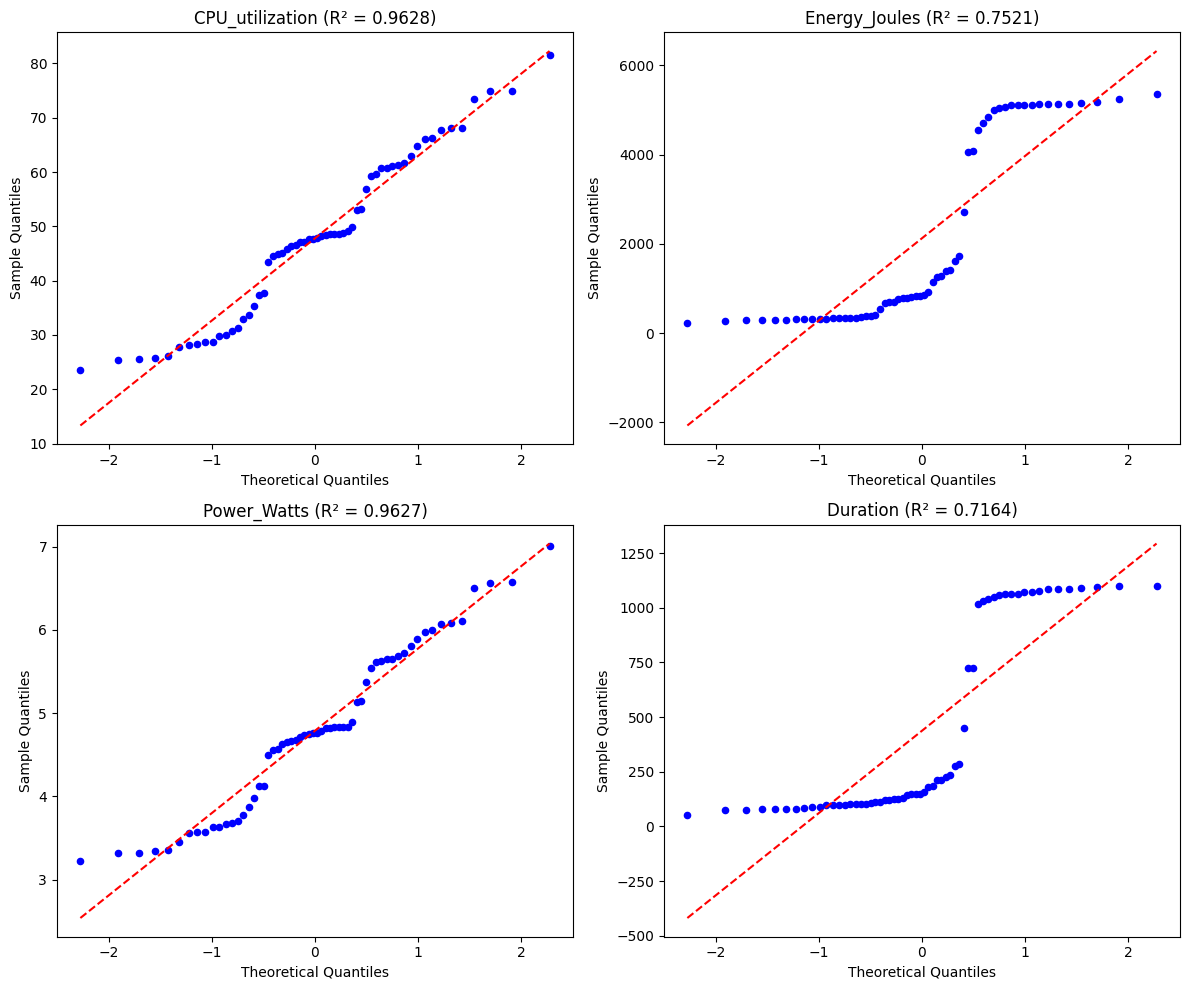

In [32]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Columns to check
columns = ["CPU_utilization", "Energy_Joules", "Power_Watts", "Duration"]

plt.figure(figsize=(12, 10))

for i, col in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    
    # Generate Q-Q plot
    (osm, osr), (slope, intercept, r) = stats.probplot(df[col], dist="norm")
    
    # Scatter points
    plt.scatter(osm, osr, color='blue', s=20)
    # Line of best fit
    plt.plot(osm, slope*osm + intercept, color='red', linestyle='--')
    
    # Compute R²
    r_squared = r**2
    plt.title(f"{col} (R² = {r_squared:.4f})")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")

plt.tight_layout()
plt.savefig("./eco_ci_downloaded_results/metrics_correlation_qqplots_with_R2.pdf")
plt.show()


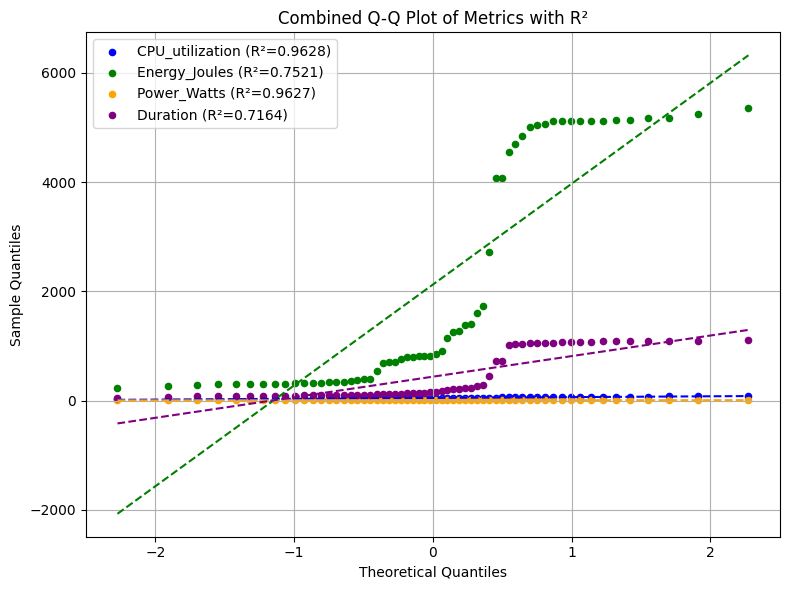

In [30]:
import matplotlib.pyplot as plt
import scipy.stats as stats

columns = ["CPU_utilization", "Energy_Joules", "Power_Watts", "Duration"]
colors = ["blue", "green", "orange", "purple"]

plt.figure(figsize=(8, 6))

for col, color in zip(columns, colors):
    # Generate Q-Q plot
    (osm, osr), (slope, intercept, r) = stats.probplot(df[col], dist="norm")
    
    # Scatter points
    plt.scatter(osm, osr, color=color, s=20, label=f"{col} (R²={r**2:.4f})")
    
    # Line of best fit
    plt.plot(osm, slope*osm + intercept, color=color, linestyle='--')

plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.title("Combined Q-Q Plot of Metrics with R²")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./eco_ci_downloaded_results/combined_qqplot_with_R2.pdf")
plt.show()


# Boxplot Energy Distribution by Cluster

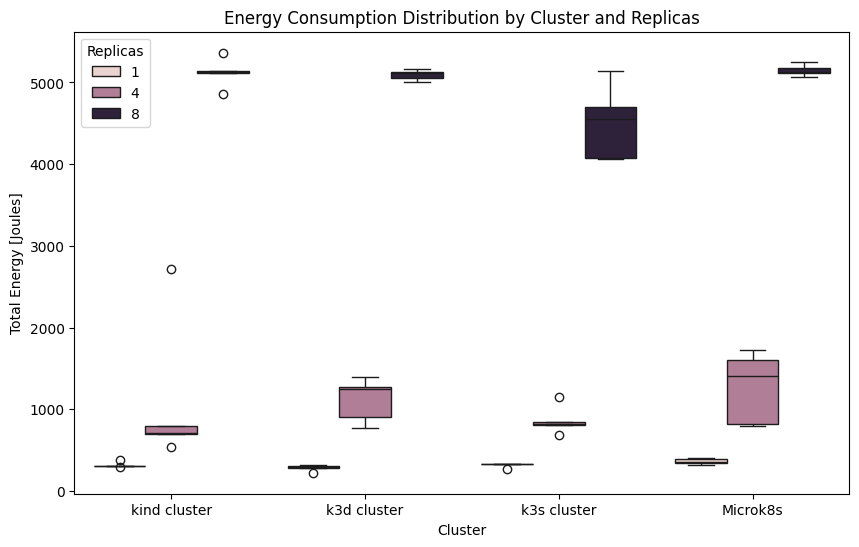

In [24]:
df = df.rename(columns={
    "avg._CPU_utilization_": "CPU_utilization",
    "avg._Power_Watts": "Power_Watts",
    "Total_Energy_Joules": "Energy_Joules",
    "Duration_Seconds": "Duration"
})

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Target", y="Energy_Joules", hue="Nb_Replicas")
plt.title("Energy Consumption Distribution by Cluster and Replicas")
plt.ylabel("Total Energy [Joules]")
plt.xlabel("Cluster")
plt.legend(title="Replicas")
plt.show()



# Scatter Energy vs Duration

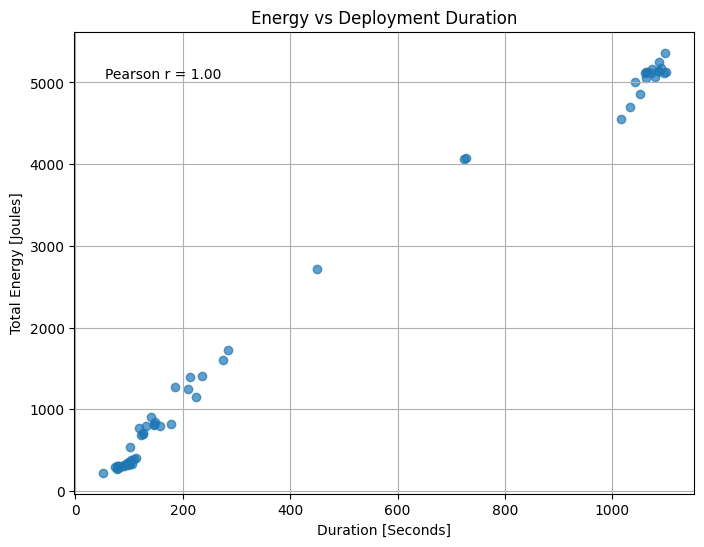

In [26]:
# Strip whitespace first
df.columns = df.columns.str.strip()

# Rename for cleaner access
df = df.rename(columns={
    "avg._CPU_utilization_": "CPU_utilization",
    "avg._Power_Watts": "Power_Watts",
    "Total_Energy_Joules": "Energy_Joules",
    "Duration_Seconds": "Duration"
})

plt.figure(figsize=(8,6))
plt.scatter(df["Duration"], df["Energy_Joules"], alpha=0.7)

plt.title("Energy vs Deployment Duration")
plt.xlabel("Duration [Seconds]")
plt.ylabel("Total Energy [Joules]")
plt.grid(True)

# Add correlation coefficient
r, _ = pearsonr(df["Duration"], df["Energy_Joules"])
plt.text(0.05, 0.9, f"Pearson r = {r:.2f}", transform=plt.gca().transAxes)

plt.show()



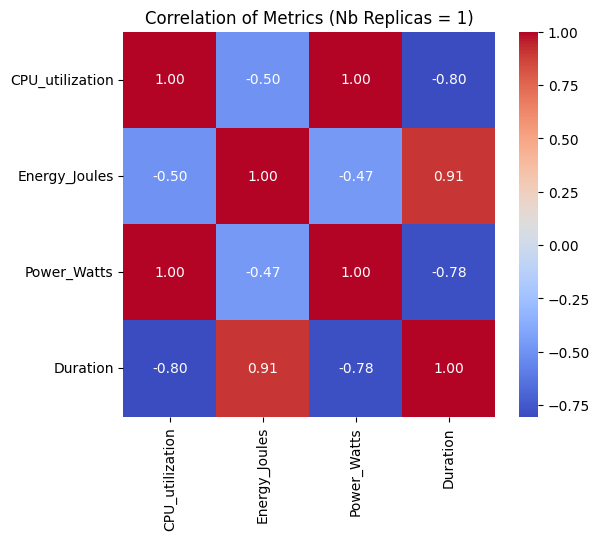

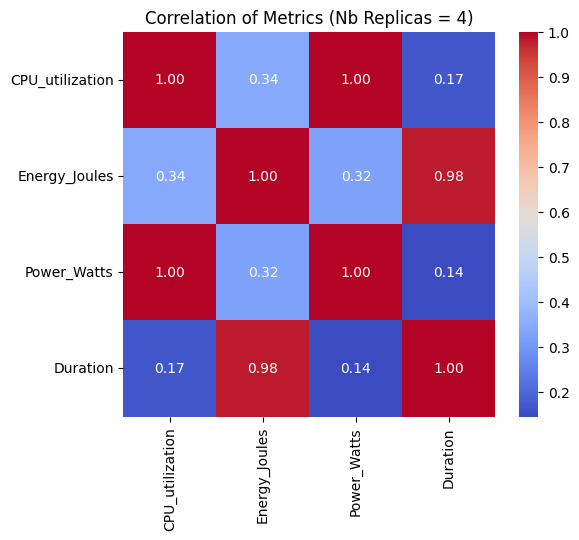

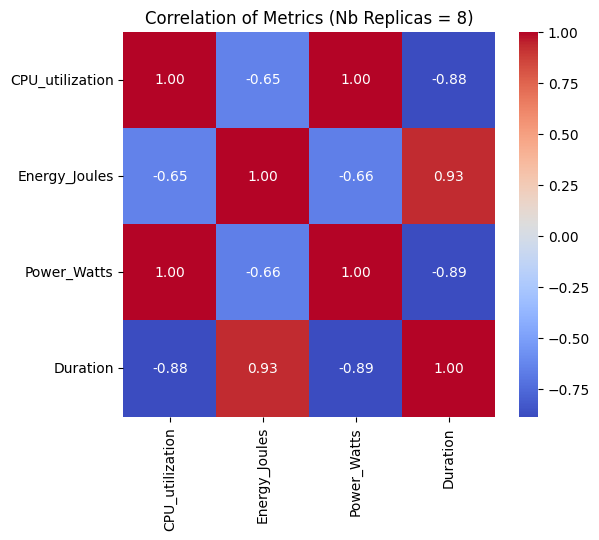

In [27]:
df = df.rename(columns={
    "avg._CPU_utilization_": "CPU_utilization",
    "avg._Power_Watts": "Power_Watts",
    "Total_Energy_Joules": "Energy_Joules",
    "Duration_Seconds": "Duration"
})

replicas = df["Nb_Replicas"].unique()
metrics = ["CPU_utilization", "Energy_Joules", "Power_Watts", "Duration"]

for r in sorted(replicas):
    subset = df[df["Nb_Replicas"] == r]
    corr = subset[metrics].corr()
    
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Correlation of Metrics (Nb Replicas = {r})")
    plt.show()

